Let's use a registered, but unmatched science image. Steps to do it:

1. copy Meredith's HiTS data, esp. for two particular visits:
```
mkdir -p HiTS_from_Meredith/processed_15A38; cd HiTS_from_Meredith/processed_15A38
lsstdevget /project/mrawls/prototype_ap/processed_15A38/0410927
lsstdevget /project/mrawls/prototype_ap/processed_15A38/0411033
cd ..
lsstdevget /project/mrawls/prototype_ap/diffim_config.py
```
3. setup `lsst_apps` and then `obs_decam` (`obs_decam` is in stack now)
4. setup `pipe_tasks` to edit:
```
git clone https://github.com/lsst/pipe_tasks; cd pipe_tasks
setup -r . -t b2803
```
4. add `templateExposure.writeFits('WARPEDTEMPLATE.fits')` at line 350 of `ip_diffim/python/ip/diffim/imagePsfMatch.py`
5. then `scons` in `pipe_tasks` and `ip_diffim`
6. cd back to `HiTS_from_Meredith`
7. remove the existing directory: `rm -r diffim_15A38_g/`
7. run `imageDifference.py`
```
$PIPE_TASKS_DIR/bin/imageDifference.py processed_15A38 --id visit=411033 ccdnum=1..3 --templateId visit=410927 --output diffim_15A38_g -C diffim_config.py --no-versions
```
8. Then in order to run the ZogyTask code below, need to set up version of `ip_diffim` with `ZogyTask`:
```
git clone https://github.com/lsst/ip_diffim; cd ip_diffim
git checkout tickets/DM-8145
setup -r . -t b2803
scons
```

In [58]:
%load_ext autoreload
%autoreload 2

## borrowed from ../notebooks/17....ipynb...

import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt

#  LSST imports:
import lsst.afw.image as afw_image
from lsst.afw.table import (SourceTable, SourceCatalog)
from lsst.meas.base import SingleFrameMeasurementConfig
from lsst.meas.algorithms import (SourceDetectionConfig, SourceDetectionTask)

import diffimTests as dit

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [59]:
import os
import sys
import lsst.utils
import lsst.afw.geom as afwGeom
import lsst.afw.image as afwImage
import lsst.afw.math as afwMath
import lsst.meas.algorithms as measAlg
import lsst.ip.diffim as ipDiffim
import lsst.ip.diffim.diffimTools as diffimTools

display = False

In [61]:
# dont bother with CCD 1, the template doesn't have a PSF.
template = afwImage.ExposureF('/Users/dreiss/DATA/HiTS_from_meredith/WARPEDTEMPLATE.fits')
science = afwImage.ExposureF('/Users/dreiss/DATA/HiTS_from_meredith/processed_15A38/0411033/calexp/calexp-0411033_01.fits')

In [62]:
import diffimTests as dit
reload(dit);

In [63]:
def ga(exposure):
    return exposure.getMaskedImage().getImage().getArray()
def gv(exposure):
    return exposure.getMaskedImage().getVariance().getArray()
def gm(exposure):
    return exposure.getMaskedImage().getMask().getArray()

stats(mean=109.1841, stdev=5.0120072, min=-189.90198, max=27233.805)
stats(mean=53.636711, stdev=5.8331966, min=-11.431186, max=6402.6104)
stats(mean=0.11522318, stdev=5.3815274, min=-194.67418, max=33651.969)
stats(mean=0.11522318, stdev=5.3815274, min=-194.67418, max=33651.969)


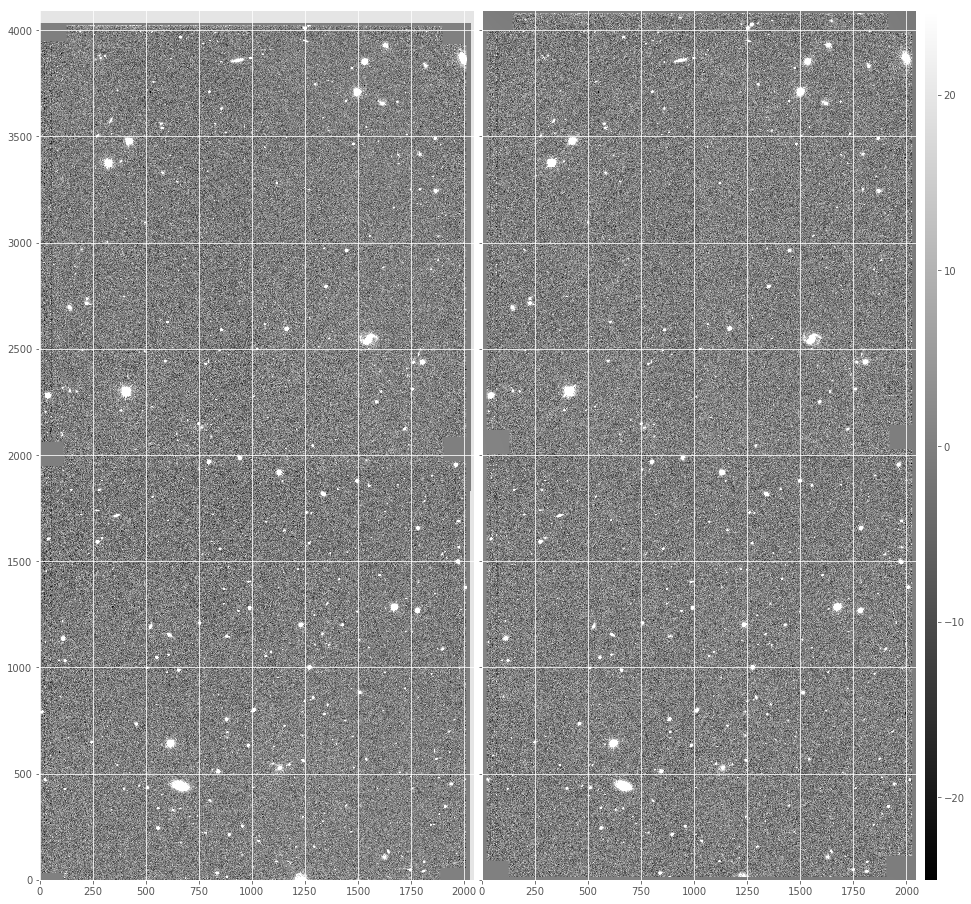

In [64]:
print dit.computeClippedImageStats(ga(template))
print dit.computeClippedImageStats(gv(template))
print dit.computeClippedImageStats(ga(science))
print dit.computeClippedImageStats(ga(science))
dit.plotImageGrid((ga(template), ga(science)), imScale=16)

In [66]:
dit.plotImageGrid((science.getPsf().computeKernelImage().getArray(),
                   template.getPsf().computeKernelImage().getArray()))

In [84]:
dit.plotImageGrid((gv(template), gv(science)), imScale=16)

In [110]:
config = ipDiffim.ZogyConfig()
task = ipDiffim.ZogyTask(templateExposure=template, scienceExposure=science, config=config)

In [111]:
D = task.computeDiffim(inImageSpace=False)

In [106]:
alDiffim = afwImage.ExposureF('/Users/dreiss/DATA/HiTS_from_meredith/diffim_15A38_g/deepDiff/v411033/diffexp-01.fits')

In [107]:
print dit.computeClippedImageStats(ga(D))
print dit.computeClippedImageStats(ga(alDiffim))
print dit.computeClippedImageStats(gv(D))
dit.plotImageGrid((ga(D), ga(alDiffim)), imScale=16)  # gv(D)

stats(mean=-109.07057, stdev=7.3537741, min=-9256.835, max=13842.176)
stats(mean=-0.56646955, stdev=7.9607038, min=-11049.172, max=16507.844)
stats(mean=118.66504, stdev=6.6951141, min=-156.59212, max=13257.299)


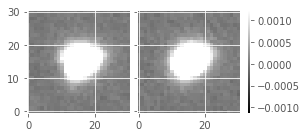

In [109]:
dit.plotImageGrid((D.getPsf().computeKernelImage().getArray(), 
                   alDiffim.getPsf().computeKernelImage().getArray()))